In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
train_loader = FromVisionDataset(vision.MNIST(True, normalize=False), batch_size=512)
test_loader = FromVisionDataset(vision.MNIST(False, normalize=False), batch_size=512)

In [4]:
encoder = builder([
    nn.Conv2d(1, 256, 9, stride=1, bias=True),
    nn.BatchNorm2d(256),
    nn.SELU(inplace=True),
    PrimaryCapsules(256, 256, 8, kernel_size=9),
    RoutingCapsules(8, 1152, 10, 16, 3)
])

decoder = builder([
    CapsuleMasked(),
    nn.Linear(160, 512),
    nn.BatchNorm1d(512),
    nn.SELU(inplace=True),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.SELU(inplace=True),
    nn.Linear(1024, 784),
    nn.Sigmoid(),
    Reg(Reshape((-1, 1, 28, 28)), 'rc', get='out'),
])

model = builder([
    Reg(Identical(), 'rc', get='out'),
    encoder,
    Split(decoder),
    Norm()
])

In [5]:
runner = Runner(model, train_loader, test_loader, 'adam', 'margin', fp16=False, multigpu=True, reg_fn={'rc': 'mse'}, reg_weights={'rc': 0.1})

In [7]:
runner.init_model()

Init xavier_normal: Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
Init xavier_normal: Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
Init xavier_normal: PrimaryCapsules(
  (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
)
Init xavier_normal: RoutingCapsules(
  (0): CapsuleLinear(8, 16)
  (1): Routing(num_routing=3)
)
Init xavier_normal: Sequential(
  (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU(inplace)
  (3): PrimaryCapsules(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (4): RoutingCapsules(
    (0): CapsuleLinear(8, 16)
    (1): Routing(num_routing=3)
  )
)
Init xavier_normal: Sequential(
  (0): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU(inplace)
  (3): PrimaryCapsules(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=

In [8]:
runner.fit(20, 1e-3)

  Epochs    train_loss    train_acc      val_loss      val_acc    
    1*        0.1983        0.8304        0.0802        0.9432    


    2         0.0413        0.9715        0.0248        0.9811    


    3         0.0304        0.9803        0.0520        0.9683    


    4         0.0248        0.9836        0.0151        0.9877    


    5         0.0213        0.9870        0.0336        0.9794    


    6         0.0186        0.9883        0.0122        0.9886    


    7         0.0148        0.9908        0.0273        0.9852    


    8         0.0179        0.9896        0.0104        0.9910    


    9         0.0131        0.9929        0.0254        0.9870    


    10        0.0125        0.9925        0.0097        0.9912    


    11        0.0114        0.9943        0.0606        0.9810    


    12        0.0122        0.9935        0.0085        0.9923    


    13        0.0092        0.9951        0.0416        0.9847    


    14        0.0114        0.9946        0.0086        0.9918    


    15        0.0084        0.9962        0.0153        0.9889    


    16        0.0081        0.9960        0.0078        0.9926    


    17        0.0066        0.9972        0.0166        0.9888    


    18        0.0094        0.9966        0.0074        0.9932    


    19        0.0069        0.9974        0.0177        0.9896    


    20        0.0069        0.9971        0.0069        0.9940    



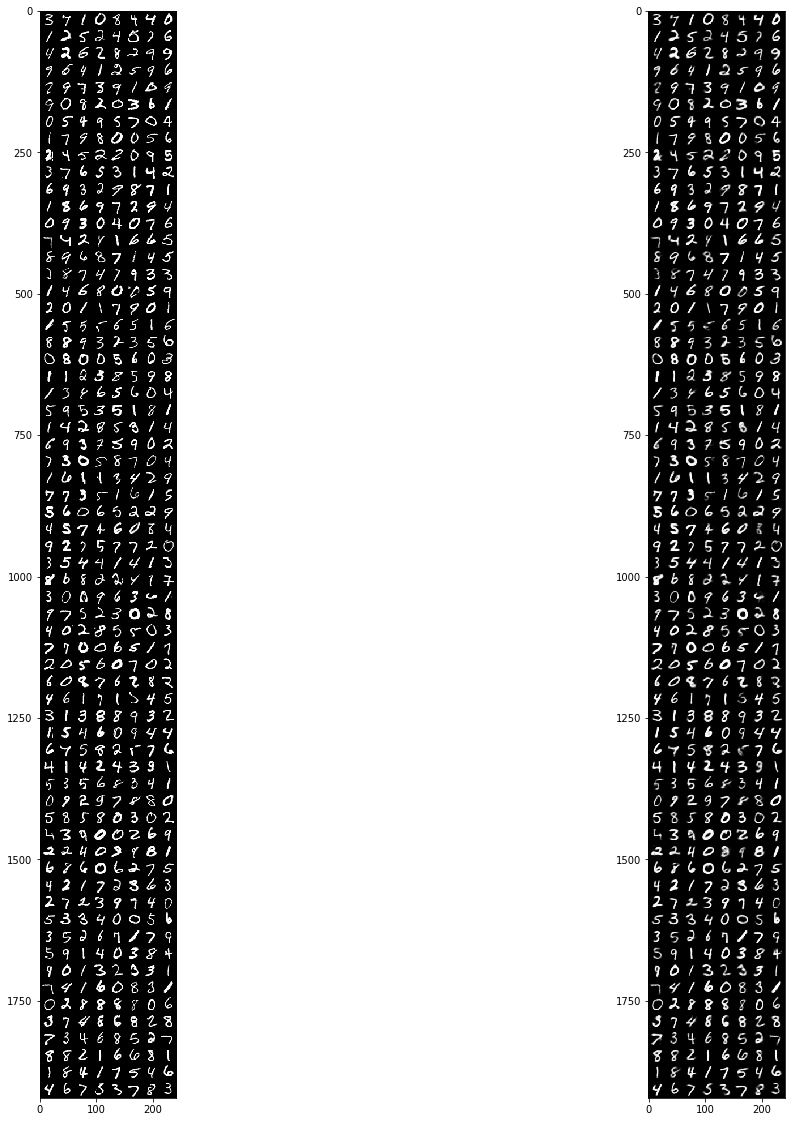

In [9]:
import torchvision.utils as vutils

x = next(iter(test_loader))[0]

out = encoder(x.cuda())
res = decoder(out)

t1 = vutils.make_grid(x).cpu().numpy().transpose(1,2,0)
t2 = vutils.make_grid(res.detach()).cpu().numpy().transpose(1,2,0)

fig, arr = plt.subplots(1,2,figsize=(20,20))
arr[0].imshow(t1)
arr[1].imshow(t2)
plt.show()